In [248]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
from lib.optimizers import *
from lib.functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## A simple function

$$M = 3, K = 2, p \in \R^M, \forall_{0 \leq i < N} \, x^{[i]} \in \R^K, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^M \to \R, \qquad f(x, p) = p_0^2 x_0 + p_1 x_1 + p_2 $$

$$ D_pf(x, p) = \left[\frac{\partial f}{\partial p_0}(x, p), \frac{\partial f}{\partial p_1}(x, p), \frac{\partial f}{\partial p_2}(x, p)\right]^T = [2p_0x_0, x_1, 1]^T$$

$$ R : \R^M \to \R^N, \qquad R(p) = \left[f(x^{[i]}, p) - y^{[i]}\right]_{0 \leq i < N} $$

$$ DR(p) = \left[\frac{\partial f}{\partial p_j}(x^{[i]}, p)\right]_{0 \leq i < N, 0 \leq j < M}$$

In [250]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]])
ys = np.array([1, 2, 3, 4, 5, 6])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0]**2 * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([2 * p[0] * x[0], x[1], 1])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return fs - ys


def residue_jacobian(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    dfs = np.array([df(x, p) for x in xs])

    return np.array([dfs[i] for i in range(len(xs))])

In [252]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(f, df, ys, xs, p)

R = Function(R_value, R_derivative, 3, 6)

In [253]:
# test that the function works properly
# p = np.array([1, 1, 1])
# R(p), R.differential(p)

## Hyperparameters

In [254]:
# p0 = np.random.randn(3)
p0 = np.array([1.4, 0.6, -3.14])
max_iter = 1000
max_iter_gd = 100000

## Gradient descent method

In [255]:
p, err = gradient_descent(R, p0, 1e-3, max_iter_gd)
print(f"{p=}, {err=}")

p=array([ 0.0419632 ,  0.99823909, -0.99823909]), err=6.009209679696455e-14


In [256]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

## Gauss-Newton method

In [257]:
p, err = gauss_newton(R, p0, max_iter, step_type="cholesky")
print(f"{p=}, {err=}")

p=array([ 1.72571447, -1.97809043,  1.97809043]), err=1.790180836524724e-15


In [258]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

In [259]:
p, err = gauss_newton(R, p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([ 0.03481567,  0.99878787, -0.99878787]), err=0.0


## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [260]:
lambda_param = 1e-3
optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)

In [261]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"{p=}, {err=}")

p=array([ 0.03483186,  0.99878674, -0.99878674]), err=4.577566798522237e-16


In [262]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

In [263]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([ 0.03483186,  0.99878674, -0.99878674]), err=8.881784197001252e-16


In [264]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr")
print(f"{p=}, {err=}")

p=array([ 0.03483186,  0.99878674, -0.99878674]), err=0.0


In [265]:
p, err = optimizer.optimize(p0, max_iter, step_type="svd")
print(f"{p=}, {err=}")

p=array([ 0.03483186,  0.99878674, -0.99878674]), err=8.881784197001252e-16


#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [266]:
optimizer = LevenbergMarquardt(
    R=R,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(
        lambda0=0.1, lambda_change=2
    ),
)

In [267]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"{p=}, {err=}")

p=array([ 0.03932075,  0.99845388, -0.99845388]), err=2.220446049250313e-16


In [268]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

In [269]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([ 0.03932075,  0.99845388, -0.99845388]), err=0.0


In [270]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr")
print(f"{p=}, {err=}")

p=array([ 0.03932075,  0.99845388, -0.99845388]), err=0.0


In [271]:
p, err = optimizer.optimize(p0, max_iter, step_type="svd")
print(f"{p=}, {err=}")

p=array([ 0.03932075,  0.99845388, -0.99845388]), err=0.0


#### Helper functions

In [272]:
_infty = 1e32
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr > _infty] = _infty
    arr[arr == 0] = _zero
    arr[arr < _zero] = _zero
    return arr

## Test parameters

In [273]:
lambda_params = [float(10**i) for i in range(-13, 3)]
np.random.seed(42)
p0s = [2**i * np.random.randn(3) for i in range(5)]
max_iter = 100
max_iter_gd = 1000

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, lambda_param in enumerate(lambda_params):
    print(f"lambda_param: {lambda_param} ({i + 1}/{len(lambda_params)})")
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda_param, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=R, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=R, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

lambda_param: 1e-13 (1/16)
lambda_param: 1e-12 (2/16)
lambda_param: 1e-11 (3/16)
lambda_param: 1e-10 (4/16)
lambda_param: 1e-09 (5/16)
lambda_param: 1e-08 (6/16)
lambda_param: 1e-07 (7/16)
lambda_param: 1e-06 (8/16)
lambda_param: 1e-05 (9/16)
lambda_param: 0.0001 (10/16)
lambda_param: 0.001 (11/16)


C:\Users\matip\AppData\Local\Temp\ipykernel_13004\3709267070.py:9: RuntimeWarning: overflow encountered in scalar power
  return p[0]**2 * x[0] + p[1] * x[1] + p[2]
C:\Users\matip\AppData\Local\Temp\ipykernel_13004\3709267070.py:9: RuntimeWarning: invalid value encountered in scalar add
  return p[0]**2 * x[0] + p[1] * x[1] + p[2]


lambda_param: 0.01 (12/16)


c:\Users\matip\Documents\UW\ml-numerki\project\lib\optimizers.py:36: RuntimeWarning: overflow encountered in matmul
  p = p - alpha * DR(p).T @ R(p)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\optimizers.py:36: RuntimeWarning: invalid value encountered in subtract
  p = p - alpha * DR(p).T @ R(p)


lambda_param: 0.1 (13/16)
lambda_param: 1.0 (14/16)
lambda_param: 10.0 (15/16)
lambda_param: 100.0 (16/16)
Gauss-Newton (step_type='least_squares') failed in iteration nr 92. Returning current point.
Gauss-Newton (step_type='least_squares') failed in iteration nr 92. Returning current point.
Gauss-Newton (step_type='least_squares') failed in iteration nr 92. Returning current point.
Gauss-Newton (step_type='least_squares') failed in iteration nr 92. Returning current point.
Gauss-Newton (step_type='least_squares') failed in iteration nr 92. Returning current point.


C:\Users\matip\AppData\Local\Temp\ipykernel_13004\3709267070.py:9: RuntimeWarning: overflow encountered in scalar multiply
  return p[0]**2 * x[0] + p[1] * x[1] + p[2]


In [274]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

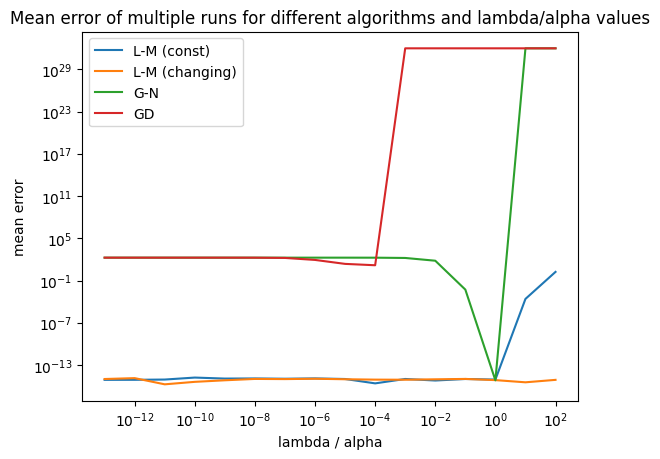

In [275]:
plt.loglog(lambda_params, errors_mean_lm_const, label="L-M (const)")
plt.loglog(lambda_params, errors_mean_lm_mod, label="L-M (changing)")
plt.loglog(lambda_params, errors_gn_mean, label="G-N")
plt.loglog(lambda_params, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("lambda / alpha")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and lambda/alpha values")
plt.show()

## Test number of iterations

In [276]:
max_iters = [2**i for i in range(0, 14)]
np.random.seed(42)
p0s = [2**i * np.random.randn(3) for i in range(5)]
alpha_gd = 1e-4
alpha_gn = 1.
lambda0 = 1.
lambda_change = 2.

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=R, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=R, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

max_iter: 1 (1/14)
max_iter: 2 (2/14)
max_iter: 4 (3/14)
max_iter: 8 (4/14)
max_iter: 16 (5/14)
max_iter: 32 (6/14)
max_iter: 64 (7/14)
max_iter: 128 (8/14)
max_iter: 256 (9/14)
max_iter: 512 (10/14)
max_iter: 1024 (11/14)
max_iter: 2048 (12/14)
max_iter: 4096 (13/14)
max_iter: 8192 (14/14)


In [277]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

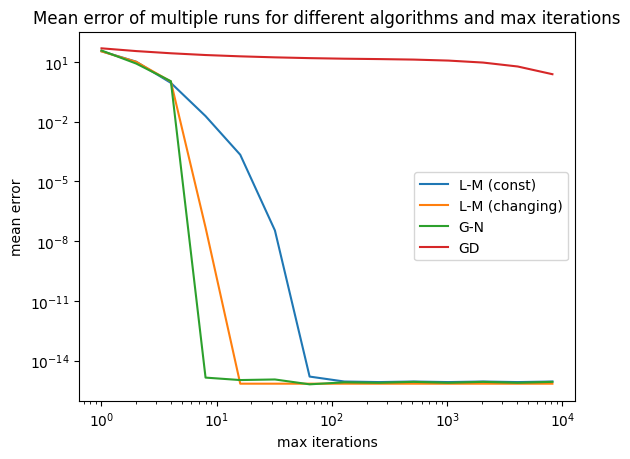

In [278]:
plt.loglog(max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_mean_lm_mod, label="L-M (changing)")
plt.loglog(max_iters, errors_gn_mean, label="G-N")
plt.loglog(max_iters, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and max iterations")
plt.show()